# Segmentation

## Configuration

First we install the necessary python libraries

In [1]:
# !pip install gluoncv --pre
# !pip install mxnet-cu100mkl --pre

We also need to download the Pascal VOC dataset for our training demonstration later.

In [2]:
# !python pascal_voc.py

In [3]:
import random
import matplotlib.image as mpimg
from datetime import datetime

import numpy as np
import mxnet as mx
from mxnet import image, autograd
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import viz
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from gluoncv.utils.parallel import *

ctx = mx.gpu(0)

## Segmentation with pre-trained models

We first download an image for the demo

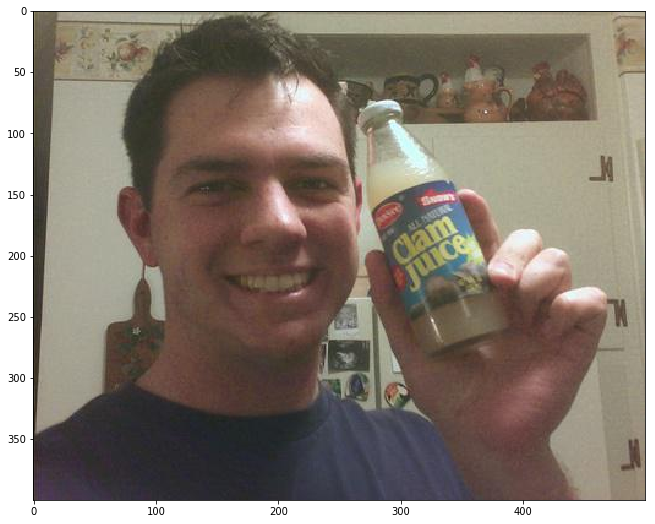

In [4]:
url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/segmentation/voc_examples/1.jpg'
filename = 'example.jpg'
gluoncv.utils.download(url, filename)
input_img = image.imread(filename)

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (15, 9)

viz.plot_image(input_img)
plt.show()

Next we define the transformation functions. It is just transformation and normalization.

In [5]:
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(ctx)
img.shape

(1, 3, 400, 500)

We'll use the pre-trained model `fcn_resnet101_voc`.

In [6]:
net = gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True, ctx=ctx)

Note we call `net.demo` here to make prediction.

In [7]:
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/model_zoo/segbase.py:92: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


With the prediction, we can extract the mask and check how it works.

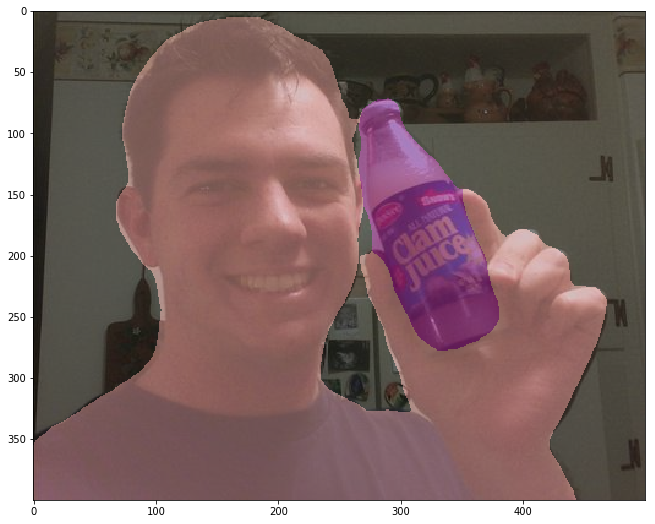

In [8]:
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Next, let's try a more difficult image.

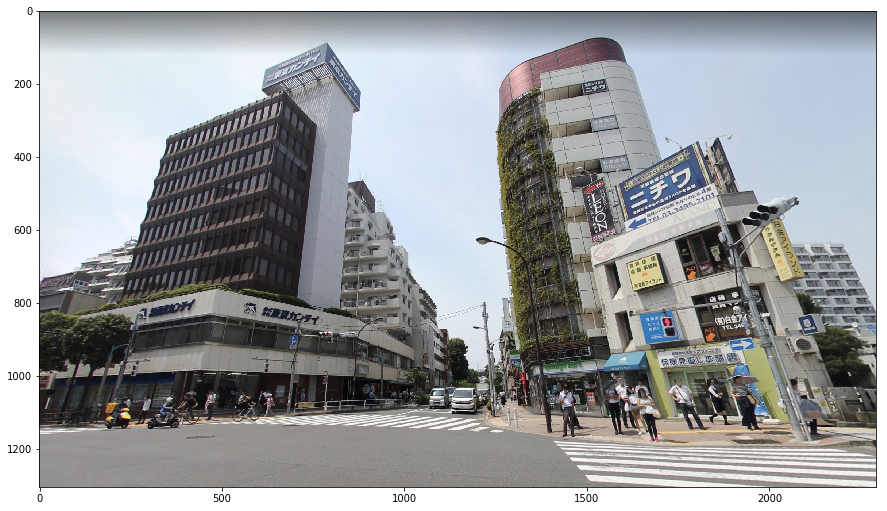

In [12]:
filename = 'streetview_meguro.jpg'
input_img = image.imread(filename)
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(ctx)

viz.plot_image(input_img)
plt.show()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/model_zoo/segbase.py:92: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


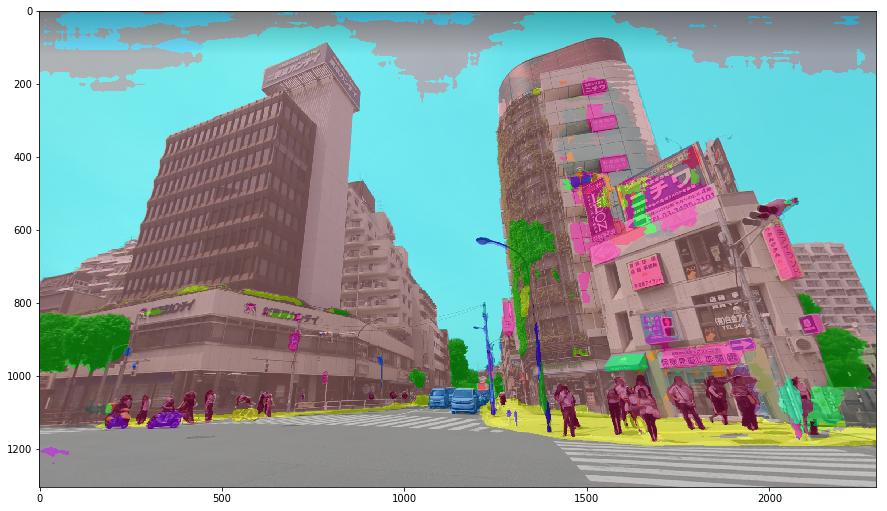

In [13]:
output = net.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Our model `fcn_resnet50_ade` overfits the sky, and is confused by the plant on the wall.

Let's try a larger one: `deeplab_resnet101_ade`.

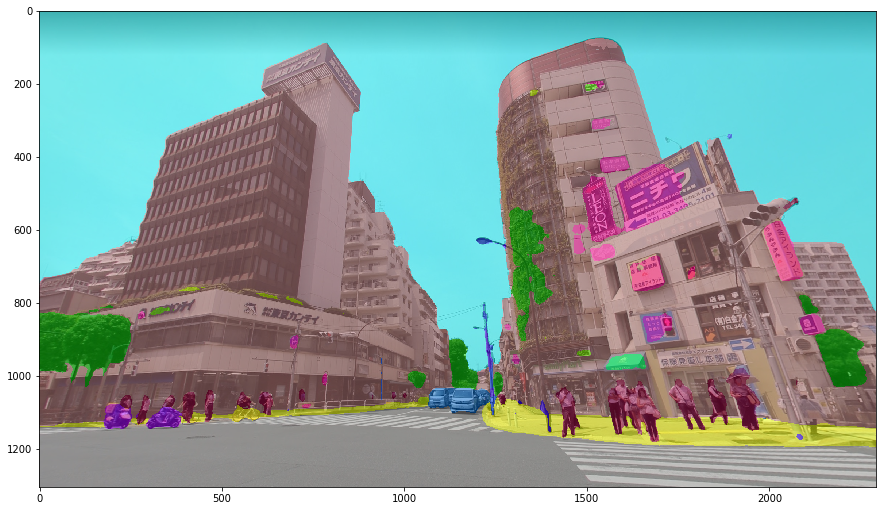

In [14]:
net = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True, ctx=ctx)
output = net.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = viz.get_color_pallete(predict, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy()) / 2
plt.imshow(combined.astype(np.uint8))
plt.show()

It is much cleaner. Although it is still a bit confused by the plant on the wall.

Remember, choose your pre-trained model based on the data.

## Training on VOC

Let's start the training of a small network `fcn_resnet50_voc`. This time we don't start from a pre-trained model, but instead we start from a randomly initialized one.

You may increase the training process to see how the quality improved.

First, let's load the model without pretrained weight.

In [15]:
net = gluoncv.model_zoo.get_model('fcn_resnet50_voc', pretrained=False)

Come back to the first image, how does the output looks like?

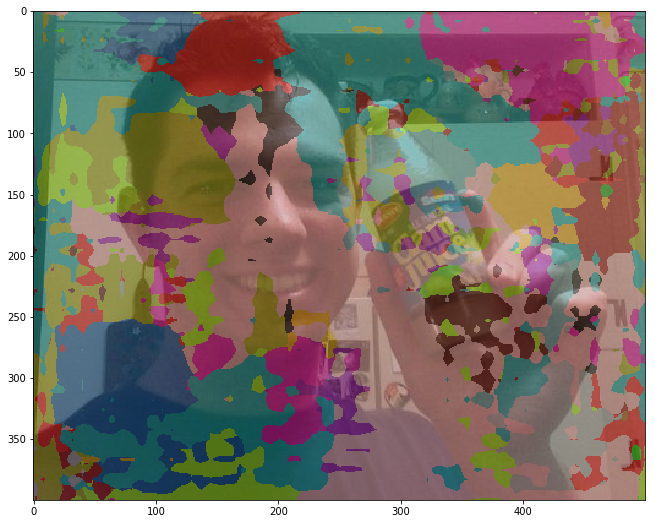

In [16]:
input_img = image.imread('example.jpg')
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0)

output = net.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

It is just random noise.

Notice: after called `net.predict()`, we need to re-define the size of `net`'s output. 

Because by calling `net.predict()` we changed the size to match the input image's, while during training `net` need a 480x480 output size.

In [17]:
from mxnet.gluon.data.vision import transforms
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])
net._up_kwargs['height'] = 480
net._up_kwargs['width'] = 480

Next we prepare the training data.

In [18]:
trainset = gluoncv.data.VOCSegmentation(split='train', transform=input_transform)
print('Training images:', len(trainset))
# set batch_size = 2 for toy example
batch_size = 4
# Create Training Loader
train_data = mx.gluon.data.DataLoader(
    trainset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=batch_size)

Training images: 2913


We randomly sample an image and its mask. This is the usual format for most segmentation training tasks.

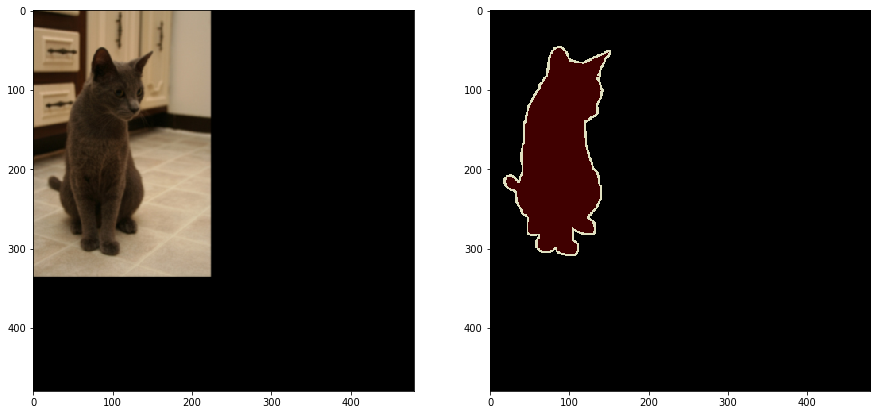

In [19]:
random.seed(datetime.now())
idx = random.randint(0, len(trainset))
img, mask = trainset[idx]
# get color pallete for visualize mask
mask = viz.get_color_pallete(mask.asnumpy(), dataset='pascal_voc')
mask.save('mask.png')
# denormalize the image
img = viz.DeNormalize([.485, .456, .406], [.229, .224, .225])(img)
img = np.transpose((img.asnumpy()*255).astype(np.uint8), (1, 2, 0))

# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)

plt.imshow(img)
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

Next we define the loss, learning rate schedule.

In [20]:
criterion = MixSoftmaxCrossEntropyLoss(aux=True)
lr_scheduler = gluoncv.utils.LRScheduler(mode='poly', baselr=0.0001, niters=len(train_data),
                                         nepochs=50)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/utils/lr_scheduler.py:94: UserWarning: baselr is deprecated. Please use base_lr.
  warnings.warn("baselr is deprecated. Please use base_lr.")


We use the `DataParallel` interface for model and loss computation. This is useful when Synchronized BatchNorm training is necessary.

In [21]:
ctx_list = [mx.gpu(i) for i in range(1)]
net = DataParallelModel(net, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

Next we define the optimizer.

In [22]:

optimizer = mx.gluon.Trainer(net.module.collect_params(), 'sgd',
                             {'lr_scheduler': lr_scheduler,
                              'wd':0.0001,
                              'momentum': 0.9,
                              'multi_precision': True})

Now we can start to train!

Remember that due to time limit we will not train until it converges.

However even by only 5 epochs' training, the result starts to make sense.

In [ ]:
for epoch in range(5):
    train_loss = 0.0
    for i, (data, target) in enumerate(train_data):
        with autograd.record(True):
            outputs = net(data)
            losses = criterion(outputs, target)
            mx.nd.waitall()
            autograd.backward(losses)
        optimizer.step(batch_size)
        for loss in losses:
            train_loss += loss.asnumpy()[0] / len(losses)
        if i % 10 == 0:
            print('Epoch %d, batch %d, training loss %.3f'%(epoch, i, train_loss/(i+1)))

Epoch 0, batch 0, training loss 4.040
Epoch 0, batch 1, training loss 3.602
Epoch 0, batch 2, training loss 2.800
Epoch 0, batch 3, training loss 2.848
Epoch 0, batch 4, training loss 2.657
Epoch 0, batch 5, training loss 2.230
Epoch 0, batch 6, training loss 2.189
Epoch 0, batch 7, training loss 2.505
Epoch 0, batch 8, training loss 2.282
Epoch 0, batch 9, training loss 3.069
Epoch 0, batch 10, training loss 2.886
Epoch 0, batch 11, training loss 2.737
Epoch 0, batch 12, training loss 2.772
Epoch 0, batch 13, training loss 2.708
Epoch 0, batch 14, training loss 2.680
Epoch 0, batch 15, training loss 2.608
Epoch 0, batch 16, training loss 2.506
Epoch 0, batch 17, training loss 2.524
Epoch 0, batch 18, training loss 2.460
Epoch 0, batch 19, training loss 2.595
Epoch 0, batch 20, training loss 2.482
Epoch 0, batch 21, training loss 2.521
Epoch 0, batch 22, training loss 2.475
Epoch 0, batch 23, training loss 2.387
Epoch 0, batch 24, training loss 2.473
Epoch 0, batch 25, training loss 2.

Epoch 0, batch 208, training loss 1.312
Epoch 0, batch 209, training loss 1.310
Epoch 0, batch 210, training loss 1.311
Epoch 0, batch 211, training loss 1.308
Epoch 0, batch 212, training loss 1.304
Epoch 0, batch 213, training loss 1.302
Epoch 0, batch 214, training loss 1.308
Epoch 0, batch 215, training loss 1.309
Epoch 0, batch 216, training loss 1.307
Epoch 0, batch 217, training loss 1.302
Epoch 0, batch 218, training loss 1.305
Epoch 0, batch 219, training loss 1.303
Epoch 0, batch 220, training loss 1.311
Epoch 0, batch 221, training loss 1.311
Epoch 0, batch 222, training loss 1.310
Epoch 0, batch 223, training loss 1.306
Epoch 0, batch 224, training loss 1.302
Epoch 0, batch 225, training loss 1.306
Epoch 0, batch 226, training loss 1.305
Epoch 0, batch 227, training loss 1.301
Epoch 0, batch 228, training loss 1.298
Epoch 0, batch 229, training loss 1.298
Epoch 0, batch 230, training loss 1.298
Epoch 0, batch 231, training loss 1.293
Epoch 0, batch 232, training loss 1.289


Epoch 0, batch 413, training loss 1.137
Epoch 0, batch 414, training loss 1.135
Epoch 0, batch 415, training loss 1.132
Epoch 0, batch 416, training loss 1.131
Epoch 0, batch 417, training loss 1.132
Epoch 0, batch 418, training loss 1.129
Epoch 0, batch 419, training loss 1.128
Epoch 0, batch 420, training loss 1.128
Epoch 0, batch 421, training loss 1.126
Epoch 0, batch 422, training loss 1.124
Epoch 0, batch 423, training loss 1.122
Epoch 0, batch 424, training loss 1.121
Epoch 0, batch 425, training loss 1.121
Epoch 0, batch 426, training loss 1.121
Epoch 0, batch 427, training loss 1.120
Epoch 0, batch 428, training loss 1.120
Epoch 0, batch 429, training loss 1.119
Epoch 0, batch 430, training loss 1.117
Epoch 0, batch 431, training loss 1.116
Epoch 0, batch 432, training loss 1.113
Epoch 0, batch 433, training loss 1.111
Epoch 0, batch 434, training loss 1.109
Epoch 0, batch 435, training loss 1.108
Epoch 0, batch 436, training loss 1.106
Epoch 0, batch 437, training loss 1.105


Let's re-predict on the image we used.

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/model_zoo/segbase.py:92: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


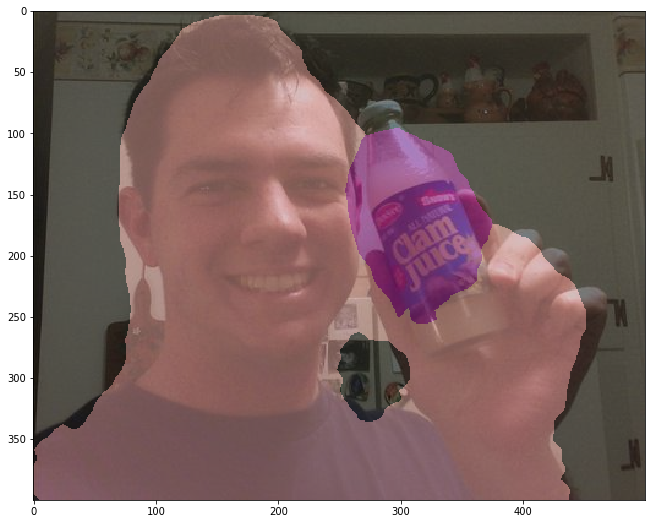

In [25]:
input_img = image.imread('example.jpg')
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])
img = transform_fn(input_img)
img = img.expand_dims(0).as_in_context(mx.gpu(0))

output = net.module.demo(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
mask = viz.get_color_pallete(predict, 'pascal_voc')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+input_img.asnumpy())/2
plt.imshow(combined.astype(np.uint8))
plt.show()

Although this is a small example, it is basically how we train a model on much larger dataset.

## Further resources

On the [GluonCV Segmentation Model Zoo](https://gluon-cv.mxnet.io/model_zoo/segmentation.html) page, we provide:

- Training scripts for FCN/PSPnet/DeepLab/Mask R-CNN on MS COCO/Pascal VOC/Cityscapes.
- Training hyperparameters to reproduce.
- Training Logs to compare speed and accuracy.